In [2]:
%pip install pandas
%pip install tensorflow


Note: you may need to restart the kernel to use updated packages.

  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.71.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl (376.0 MB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached flat

In [5]:
# ----------------------------
# 1. Import libraries
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import statsmodels.api as sm
import pmdarima as pm
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, LayerNormalization, MultiHeadAttention, Add

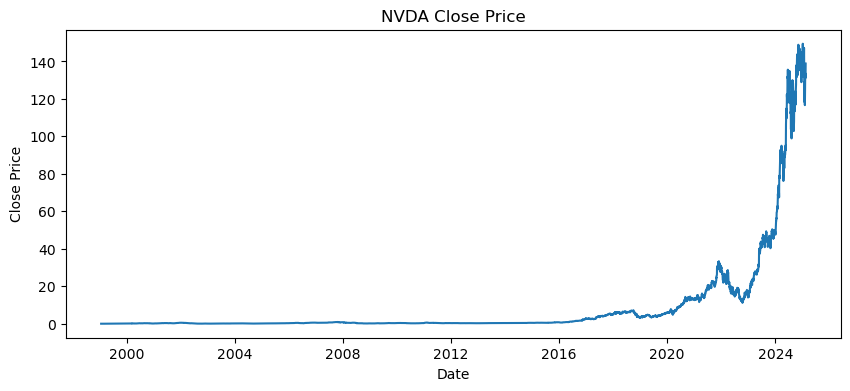

In [6]:
# ----------------------------
# 2. Load and preprocess data
# ----------------------------
# Load NVDA.csv (adjust the path as needed)
df = pd.read_csv("NVDA.csv", parse_dates=["Date"], index_col="Date")
df.sort_index(inplace=True)

# Use the "Close" price as the target for forecasting
data = df['Close'].copy()

# Optionally, plot the series to inspect it
plt.figure(figsize=(10, 4))
plt.plot(data)
plt.title("NVDA Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [9]:
# ----------------------------
# 3. Split into training and testing sets
# ----------------------------
# For instance, we use the last 20% of data as test set
split_index = int(len(data) * 0.8)
train, test = data.iloc[:split_index], data.iloc[split_index:]
print("Train set size:", len(train))
print("Test set size:", len(test))


Train set size: 5246
Test set size: 1312


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16654.063, Time=4.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16631.615, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16636.100, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16635.964, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16631.276, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16637.721, Time=2.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16632.534, Time=2.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-16655.594, Time=4.73 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-16646.887, Time=0.62 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-16696.988, Time=7.76 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-16646.813, Time=2.29 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-16694.696, Time=9.11 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-16682.094, Time=8.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-16668.458, Time=7.92 sec
 ARIM

d:\APP\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\APP\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
d:\APP\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\APP\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\APP\Anaconda\Lib\site-

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5246
Model:               SARIMAX(4, 1, 2)   Log Likelihood                8345.489
Date:                Tue, 25 Mar 2025   AIC                         -16676.978
Time:                        06:42:31   BIC                         -16631.028
Sample:                             0   HQIC                        -16660.911
                               - 5246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6757      0.025    -26.552      0.000      -0.726      -0.626
ar.L2         -0.7146      0.022    -32.866      0.000      -0.757      -0.672
ar.L3          0.0427      0.006      6.642      0.0

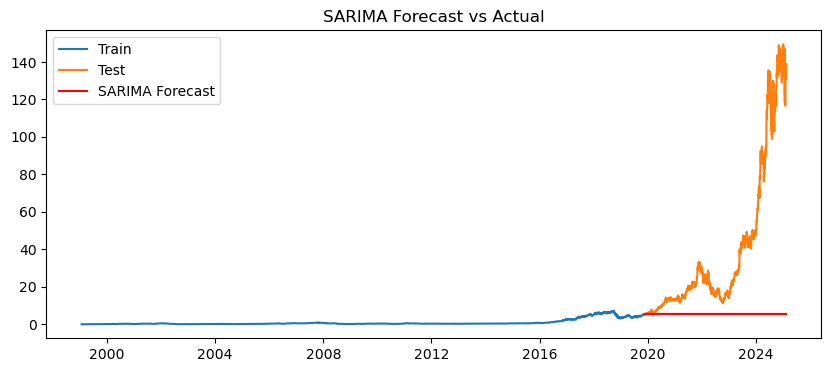

In [12]:
# ----------------------------
# 4. (A) Traditional methods: ARIMA & SARIMA
# ----------------------------
# (i) Auto ARIMA to select best (p, d, q) and seasonal parameters (if any)
auto_model = pm.auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
p, d, q = auto_model.order
print("Best ARIMA order:", (p, d, q))

# ----- FIXED CODE: Use get_forecast() for out-of-sample prediction -----
n_periods = len(test)
forecast_results = arima_results.get_forecast(steps=n_periods)
arima_pred = forecast_results.predicted_mean
# Assign the test index to the predictions for proper alignment:
arima_pred.index = test.index

rmse_arima = sqrt(mean_squared_error(test, arima_pred))
mae_arima = mean_absolute_error(test, arima_pred)
print("ARIMA - RMSE:", rmse_arima, " MAE:", mae_arima)

# (ii) SARIMA (if seasonality is expected, here we show the framework)
# For illustration, we set seasonal_order; adjust m (seasonality period) if needed.
seasonal_order = (0, 0, 0, 0)  # change if seasonality is detected
sarima_model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q),
                                         seasonal_order=seasonal_order,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
sarima_results = sarima_model.fit(disp=False)
print(sarima_results.summary())

# ----- FIXED CODE: Forecast SARIMA using get_forecast() -----
n_periods = len(test)  # Number of steps in the test set
forecast_results_sarima = sarima_results.get_forecast(steps=n_periods)
sarima_pred = forecast_results_sarima.predicted_mean
sarima_pred.index = test.index  # Align the forecast index with the test index

rmse_sarima = sqrt(mean_squared_error(test, sarima_pred))
mae_sarima = mean_absolute_error(test, sarima_pred)
print("SARIMA - RMSE:", rmse_sarima, " MAE:", mae_sarima)

# Plot forecasts
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, sarima_pred, label="SARIMA Forecast", color="red")
plt.legend()
plt.title("SARIMA Forecast vs Actual")
plt.show()



In [13]:
# ----------------------------
# 5. (B) Deep Learning models
# ----------------------------
# We prepare the data for deep learning by scaling and creating sliding windows.

from sklearn.preprocessing import MinMaxScaler

# Scale the data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1,1))

def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 20  # number of timesteps as input
X, y = create_dataset(scaled_data, window_size)
print("Input shape:", X.shape)

# Split into training and test sets for DL models using same ratio
split_dl = int(0.8 * len(X))
X_train, X_test = X[:split_dl], X[split_dl:]
y_train, y_test = y[:split_dl], y[split_dl:]

# (i) LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

# Train LSTM
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Forecast using LSTM
lstm_pred = lstm_model.predict(X_test)
# Inverse transform predictions
lstm_pred_inv = scaler.inverse_transform(lstm_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Evaluate LSTM
rmse_lstm = sqrt(mean_squared_error(y_test_inv, lstm_pred_inv))
mae_lstm = mean_absolute_error(y_test_inv, lstm_pred_inv)
print("LSTM - RMSE:", rmse_lstm, " MAE:", mae_lstm)

# (ii) Transformer-based Model for Time Series Forecasting
# A simplified transformer block using Keras functional API

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Multi-Head Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])
    
    # Feed-Forward part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

# Build Transformer model architecture
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = tf.keras.layers.Flatten()(x)
    for units in mlp_units:
        x = Dense(units, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    return model

input_shape = (window_size, 1)
transformer_model = build_transformer_model(input_shape,
                                            head_size=32,
                                            num_heads=2,
                                            ff_dim=32,
                                            num_transformer_blocks=2,
                                            mlp_units=[64],
                                            dropout=0.1,
                                            mlp_dropout=0.1)
transformer_model.compile(optimizer="adam", loss="mse")
transformer_model.summary()

# Train the Transformer model
history_trans = transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Forecast using Transformer
trans_pred = transformer_model.predict(X_test)
trans_pred_inv = scaler.inverse_transform(trans_pred)
# Evaluate Transformer
rmse_trans = sqrt(mean_squared_error(y_test_inv, trans_pred_inv))
mae_trans = mean_absolute_error(y_test_inv, trans_pred_inv)
print("Transformer - RMSE:", rmse_trans, " MAE:", mae_trans)

Input shape: (6538, 20, 1)


d:\APP\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.1534e-05 - val_loss: 1.5680e-05
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6649e-06 - val_loss: 6.5538e-06
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5169e-06 - val_loss: 6.4330e-06
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5519e-06 - val_loss: 7.1093e-06
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3962e-06 - val_loss: 1.0607e-05
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1591e-06 - val_loss: 6.2167e-06
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4387e-06 - val_loss: 8.9323e-06
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2680e-06 - val_loss: 6.8852e-06
Epoch 9/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0548e-06 - val_loss: 4.1029e-06
Epoch 10/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0520e-06 - val_loss: 4.1376e-06
Epoch 11/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - los

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 20, 1)     │          2 │ input_layer_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 1)     │        449 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 20, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 1)     │          0 │ dropout_2[0][0],  │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20, 32)    │         64 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 20, 32)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20, 1)     │         33 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 20, 1)     │          0 │ dense_2[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 1)     │        449 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 20, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 20, 1)     │          0 │ dropout_5[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 20, 32)    │         64 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 20, 32)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 20, 1)     │         33 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 20, 1)     │          0 │ dense_4[0][0],    │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,511 (9.81 KB)

 Trainable params: 2,511 (9.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 2.8502e-05 - val_loss: 9.4460e-04
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3773e-05 - val_loss: 9.5478e-04
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3834e-05 - val_loss: 9.8932e-04
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6685e-05 - val_loss: 0.0010
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5979e-05 - val_loss: 9.8353e-04
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.6054e-05 - val_loss: 0.0010
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.6579e-05 - val_loss: 9.6811e-04
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.3741e-05 - val_loss: 9.5803e-04
Epoch 9/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.3613e-05 - val_loss: 9.7990e-04
Epoch 10/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5798e-05 - val_loss: 9.0982e-04
Epoch 11/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - los


--- Model Comparison ---
ARIMA    - RMSE: 53.06, MAE: 34.50
SARIMA   - RMSE: 53.06, MAE: 34.50
LSTM     - RMSE: 22.74, MAE: 14.53
Transformer - RMSE: 56.48, MAE: 39.53


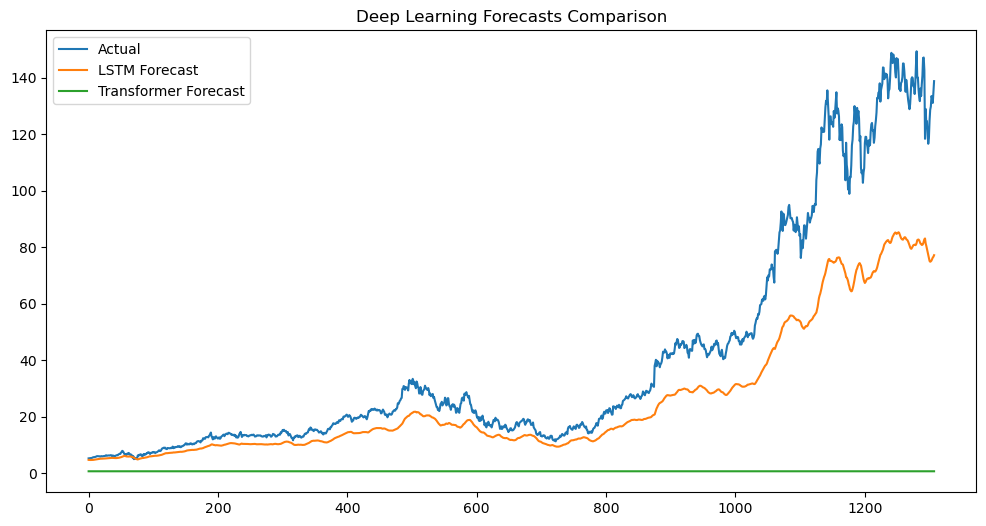

In [14]:
# ----------------------------
# 6. (C) Model Comparison & Reporting
# ----------------------------
print("\n--- Model Comparison ---")
print("ARIMA    - RMSE: {:.2f}, MAE: {:.2f}".format(rmse_arima, mae_arima))
print("SARIMA   - RMSE: {:.2f}, MAE: {:.2f}".format(rmse_sarima, mae_sarima))
print("LSTM     - RMSE: {:.2f}, MAE: {:.2f}".format(rmse_lstm, mae_lstm))
print("Transformer - RMSE: {:.2f}, MAE: {:.2f}".format(rmse_trans, mae_trans))

# Optionally, plot forecasts from the three deep learning models for a visual comparison
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(y_test), label="Actual")
plt.plot(lstm_pred_inv, label="LSTM Forecast")
plt.plot(trans_pred_inv, label="Transformer Forecast")
plt.legend()
plt.title("Deep Learning Forecasts Comparison")
plt.show()

In [15]:
# ----------------------------
# 7. Report Summary
# ----------------------------
report = f"""
Model Performance Report:
-------------------------
Traditional Methods:
 - ARIMA    -> RMSE: {rmse_arima:.2f}, MAE: {mae_arima:.2f}
 - SARIMA   -> RMSE: {rmse_sarima:.2f}, MAE: {mae_sarima:.2f}

Deep Learning Models:
 - LSTM     -> RMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f}
 - Transformer -> RMSE: {rmse_trans:.2f}, MAE: {mae_trans:.2f}

Discussion:
- Traditional models (ARIMA/SARIMA) provide interpretable parameters and are based on statistical assumptions.
- Deep learning models (LSTM and Transformer) may achieve better accuracy on non-linear patterns but at the cost of interpretability.
- The trade-off between accuracy and explainability should be considered based on the use-case.
"""
print(report)



Model Performance Report:
-------------------------
Traditional Methods:
 - ARIMA    -> RMSE: 53.06, MAE: 34.50
 - SARIMA   -> RMSE: 53.06, MAE: 34.50

Deep Learning Models:
 - LSTM     -> RMSE: 22.74, MAE: 14.53
 - Transformer -> RMSE: 56.48, MAE: 39.53

Discussion:
- Traditional models (ARIMA/SARIMA) provide interpretable parameters and are based on statistical assumptions.
- Deep learning models (LSTM and Transformer) may achieve better accuracy on non-linear patterns but at the cost of interpretability.
- The trade-off between accuracy and explainability should be considered based on the use-case.

